In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1] Read input data
#### 1.1] The input dataframe contains SKU [Stock Keeping Unit] data for a particular commodity
#### 1.2] There are 648 rows and 28 feature columns
#### 1.3] Of the 28 feature columns, 21 are numeric and 5 are alpha-numeric
#### About the data:
##### The raw input features have been processed based on their distribution. Due to the confidentiality of the raw data, it has not shown in this notebook
##### The features of the raw data have been processed as follows:
##### a] If the feature has normal distribution, then the feature has been normalized -- (X - mean)/std
##### b] If the feature did not follow a normal distribution, then a 2 step process was applied. 1] The feature value was replaced with their respective quantiles 2] Min-max scaling was applied to the quantiles
##### c] If the feature was categorical, then one-hot encoding was used

In [19]:
# Read in the data
# Main change from v2 to v3 is that the specific regions have been replaced with general regions
cmd_data = pd.read_csv('/data2/home/prasannaiyer/Projects/SKU_Cluster_Local/SKU_Clusters/Data/cmd_attributes_v3_upload.csv',\
    encoding = 'latin-1', decimal = '.', thousands = ',')

In [20]:
cmd_data.shape

(648, 28)

In [21]:
cmd_data.dtypes.value_counts()

int64      16
object      7
float64     5
dtype: int64

In [22]:
# Replace the values in p_bu: {'AW': 'AG', 'CW': 'CE'}
cmd_data['p_bu'] = cmd_data['p_bu'].replace({'AW': 'AG', 'CW': 'CE'})

In [34]:
total_skus = cmd_data.shape[0]

## 2] Exploratory Data Analysis

#### 2.1] Correlation plot
####    Focusing on Attr3_Costamount_norm (overall):
#### a] Attr4 and Attr5 have the highest correlation with cost. This is intuitive as the Attr4 and Attr5 describe the geometry of the commodity SKU and therefore majorly influence the cost
#### b] Attr1 and Attr9 also show meaningful correlation with cost. Attr1 partially reflects the geometry. Attr9 indicates a special welding requirement and therefore the impact on cost is as expected
#### Other observations
#### e] Attr9 shows meaningful correlation with Attr4 and Attr5. This indicates that enhanced geometry influences the need for the special welding requirement

Text(0.5, 1.0, 'Correlation Matrix of Commodity Data')

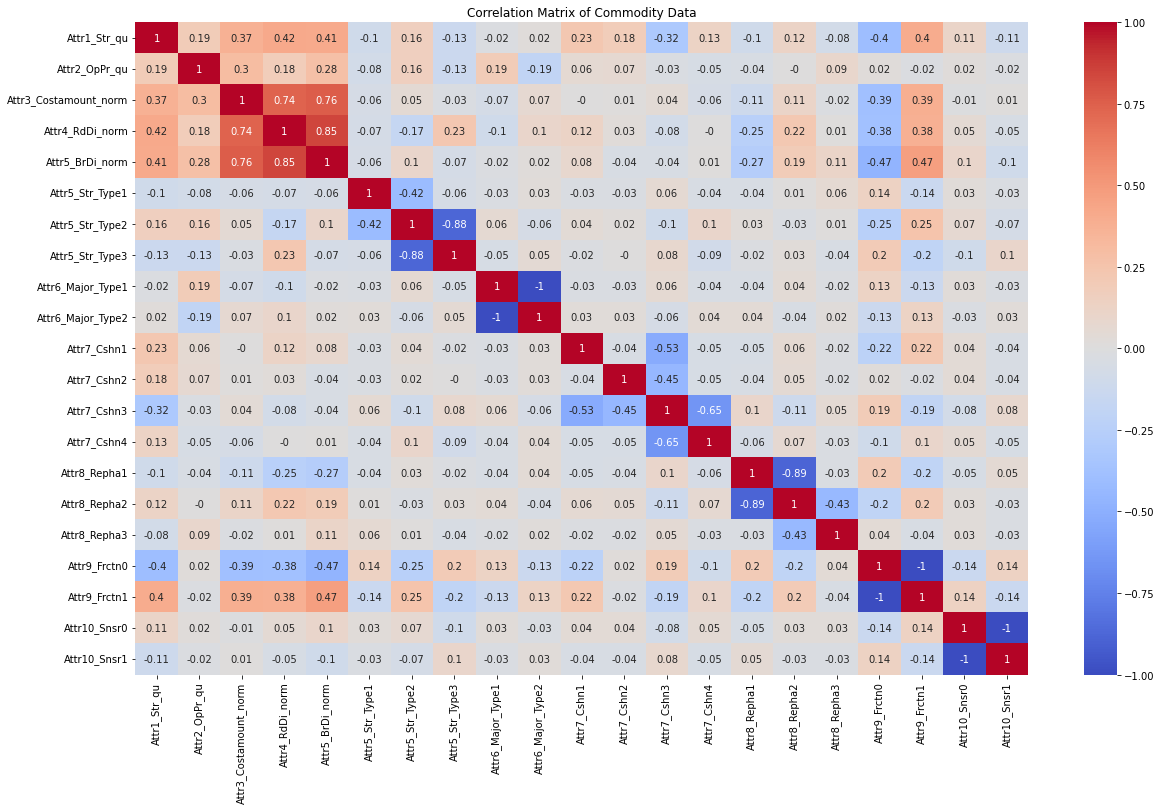

In [23]:
# Plot the correlation matrix
fig = plt.figure(figsize = (20, 12))
corr = cmd_data.corr()
#set the precision in corr dataframe to 2
corr = corr.round(2)
ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm')
ax.set_title('Correlation Matrix of Commodity Data')
#plt.xticks(rotation = 45)

Text(0.5, 1.0, 'Correlation Matrix of Commodity Data - Specific Attributes')

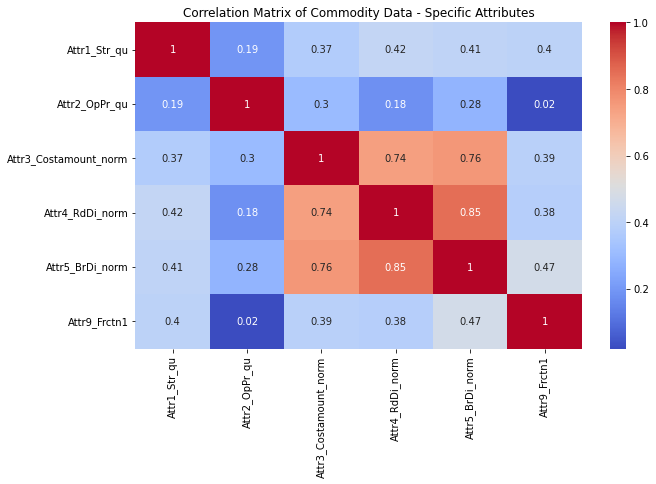

In [24]:
#Attributes for correlation matrix
corr_attributes = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm', 'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn1']
# show the correlation matrix for corr_attributes
fig = plt.figure(figsize = (10, 6))
corr = cmd_data[corr_attributes].corr().abs()
#set the precision in corr dataframe to 2
corr = corr.round(2)
ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm')
ax.set_title('Correlation Matrix of Commodity Data - Specific Attributes')

####    Focusing on Attr3_Costamount_norm (by region): Attribute with highest correlation with Attr3_Costamount_norm varies by region
#### a] Region 1: Attr5_BrDi_Norm [related to SKU geometry] 
#### b] Region 2: Attr1_Str_qu
#### c] Region 3: Attr5_BrDi_norm [related to SKU geometry]
#### d] Region 4: Attr5_RdDi_norm [related to SKU geometry]

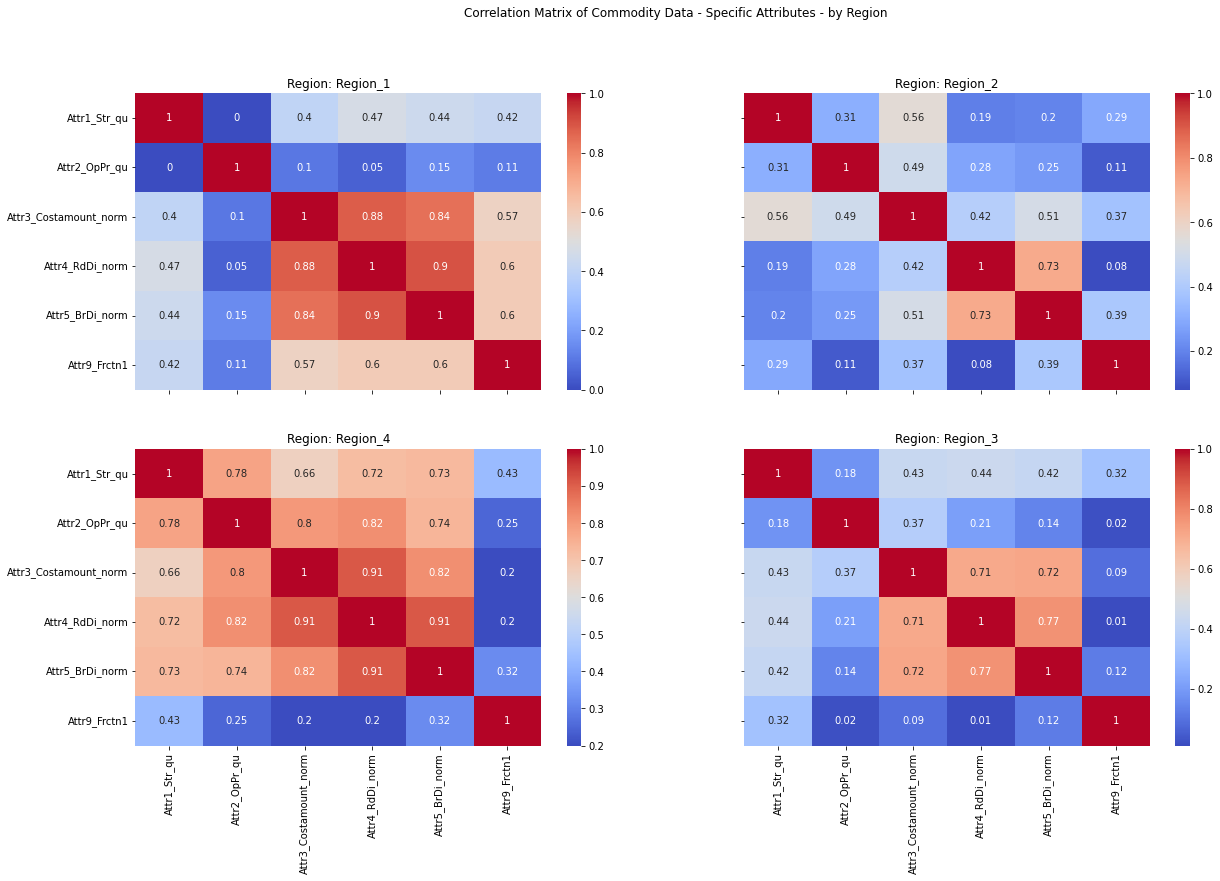

In [25]:
# plot a grid showing the correlation matrix for the different p_region values in cmd_data
# share the same x-axis and y-axis
fig, axes = plt.subplots(2, 2, figsize = (20, 12), sharex = True, sharey = True)
fig.suptitle('Correlation Matrix of Commodity Data - Specific Attributes - by Region')
for i, p_region in enumerate(cmd_data['p_region'].unique()):
    corr = cmd_data[cmd_data['p_region'] == p_region][corr_attributes].corr().abs()
    #set the precision in corr dataframe to 2
    corr = corr.round(2)
    ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = axes[i // 2, i % 2])
    ax.set_title('Region: ' + p_region)

#### While focusing on Attr3_Costamount_norm correlations among the main P_BU values:
##### For p_bu = 'AG', Attr4 & Attr5 have the most correlation with Attr3_Costamount_norm, followed by Attr9 & Attr1
##### For p_bu = 'CE', Attr4 & Attr5 have the most correlation with Attr3_Costamount_norm [correlation values are greater than p_bu = 'AG'], followed by Attr2. Attr9 does not show much variation for p_bu = 'CE' and therefore, the lack of strong correlation with Attr3_Costamount_norm is not surprising

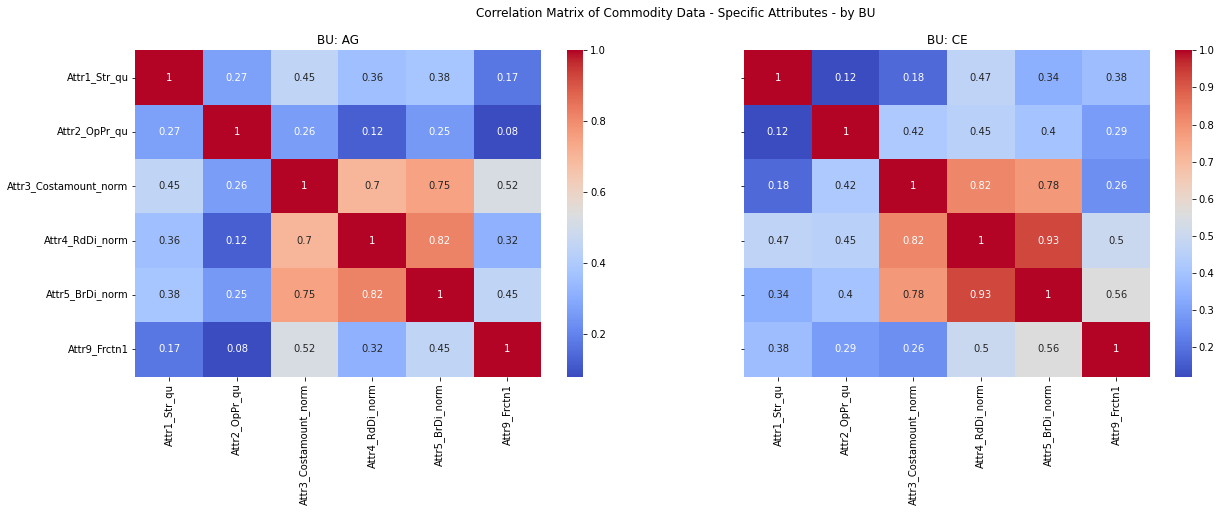

In [26]:
# Plot a grid showing the correlation matrix for the different p_bu values in cmd_data
# share the same x-axis and y-axis
fig, axes = plt.subplots(1, 2, figsize = (20, 6), sharex = True, sharey = True)
fig.suptitle('Correlation Matrix of Commodity Data - Specific Attributes - by P_BU')
for i, p_bu in enumerate(['AG', 'CE']):
    corr = cmd_data[cmd_data['p_bu'] == p_bu][corr_attributes].corr().abs()
    #set the precision in corr dataframe to 2
    corr = corr.round(2)
    ax = sns.heatmap(corr, annot = True, cmap = 'coolwarm', ax = axes[i])
    ax.set_title('P_BU: ' + p_bu)

#### p_bu = 'CE' has the highest sum of Attr9_Frctn1 [special welding requirement]. 76% of SKUs with p_bu = 'CE' have Attr9_Frct1 = 1

[Text(0, 3, '56 (9%)'), Text(0, 3, '128 (20%)'), Text(0, 3, '78 (12%)')]

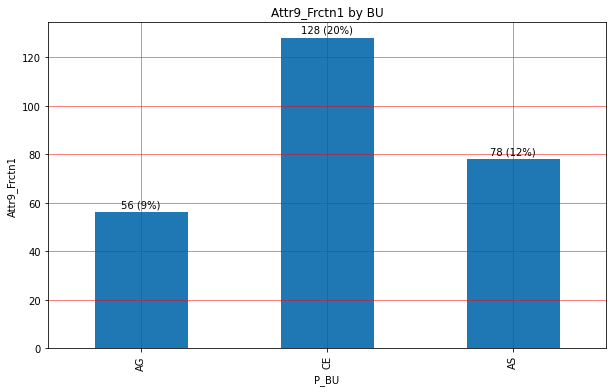

In [37]:
ax = cmd_data.groupby(by = 'p_bu')['Attr9_Frctn1'].sum().loc[['AG', 'CE', 'AS']].plot(kind = 'bar', figsize = (10, 6), title = 'Attr9_Frctn1 by BU')
ax.set_ylabel('Attr9_Frctn1')
ax.set_xlabel('P_BU')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues], padding = 3)



In [28]:
sku_attributes = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr7_Cshn1', 'Attr7_Cshn2', 'Attr7_Cshn3',
       'Attr7_Cshn4', 'Attr8_Repha1', 'Attr8_Repha2', 'Attr8_Repha3',
       'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1',
       'partnumber']

In [29]:
cmd_sku_data = cmd_data.groupby(by = sku_attributes)['Attr3_Costamount_norm'].mean().reset_index()

#### Region_1 has the most number of SKUs at 48% of total, followed by Region_2 at 31% of total

[Text(0, 0, '311 (48%)'),
 Text(0, 0, '201 (31%)'),
 Text(0, 0, '84 (13%)'),
 Text(0, 0, '52 (8%)')]

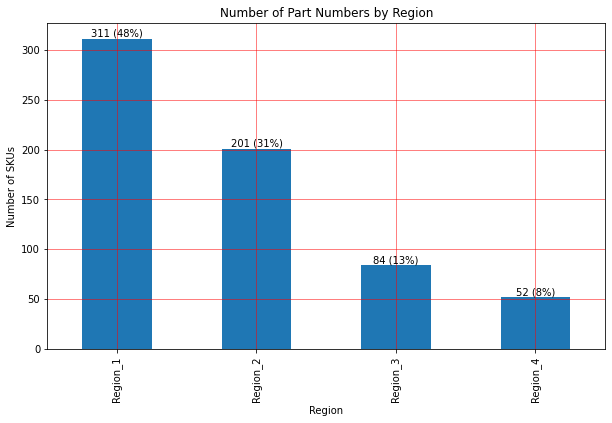

In [30]:
ax = cmd_data.groupby(by = 'p_region')['partnumber'].count().plot(kind = 'bar', title = 'Number of Part Numbers by Region', figsize = (10, 6))
ax.set_xlabel('Region')
ax.set_ylabel('Number of SKUs')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues])


#### p_bu = 'AG' has the most number of SKUs at 44% of total, followed by p_bu = 'AS' at 30%

[Text(0, 0, '288 (44%)'), Text(0, 0, '194 (30%)'), Text(0, 0, '166 (26%)')]

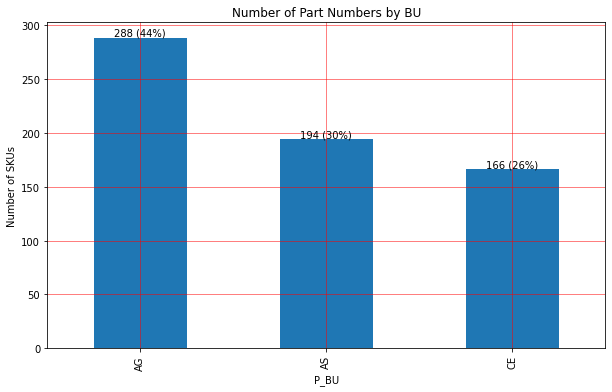

In [31]:
ax = cmd_data.groupby(by = 'p_bu')['partnumber'].count().plot(kind = 'bar', title = 'Number of Part Numbers by BU', figsize = (10, 6))
ax.set_xlabel('P_BU')
ax.set_ylabel('Number of SKUs')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.0f} ({(x/total_skus)*100:,.0f}%)' for x in ax.containers[0].datavalues])

[Text(0, 0, '0.34'),
 Text(0, 0, '-0.38'),
 Text(0, 0, '-0.11'),
 Text(0, 0, '-0.34')]

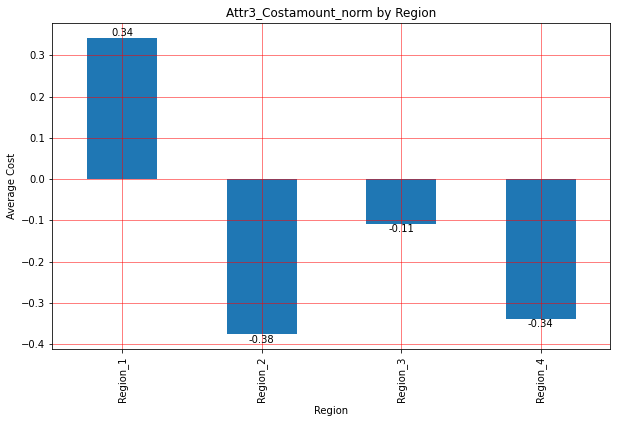

In [38]:
# Plot the average attr3_costamount_norm by region
ax = cmd_data.groupby(by = 'p_region')['Attr3_Costamount_norm'].mean().plot(kind = 'bar', title = 'Attr3_Costamount_norm by Region', figsize = (10, 6))
ax.set_xlabel('Region')
ax.set_ylabel('Average Cost')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.bar_label(ax.containers[0], labels = [f'{x:,.02f}' for x in ax.containers[0].datavalues])